## 1. Setup and Imports
This section installs and imports required libraries, loads results, and prepares the combined dataframe.

In [3]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"

paths = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

dfs = []
for name, p in paths.items():
    dfp = pd.read_csv(p).copy()
    dfp["model"] = name
    dfs.append(dfp)

all_df = pd.concat(dfs, ignore_index=True)
print("Rows per model:")
display(all_df.groupby("model").size())
all_df.head()


Rows per model:


model
PyAnnote       60
Simple         60
SpeechBrain    60
dtype: int64

,audio,language,true_speakers,pred_speakers,runtime_sec,model
0,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,16.593641,PyAnnote
1,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,13.713065,PyAnnote
2,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,2,2,9.936236,PyAnnote
3,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,11.928650,PyAnnote
4,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,3,13.806100,PyAnnote


## 2. Overall Metrics by Model
This section computes and displays overall metrics for each model.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rows = []
for model, g in all_df.groupby("model"):
    y_true = g["true_speakers"].astype(int)
    y_pred = g["pred_speakers"].fillna(-1).astype(int)
    rows.append({
        "model": model,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    })

summary = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("=== Overall metrics by model ===")
display(summary)

# optional: save summary
(summary).to_csv(R / "benchmark_summary_overall.csv", index=False)


=== Overall metrics by model ===


,model,accuracy,precision_macro,recall_macro,f1_macro
0,PyAnnote,0.866667,0.675134,0.65,0.660578
1,SpeechBrain,0.400000,0.301136,0.40,0.322917
2,Simple,0.350000,0.446328,0.35,0.200522


## 3. Per-Language Metrics by Model
This section computes and displays metrics for each model, broken down by language.

In [6]:
rows = []
for (model, lang), g in all_df.groupby(["model","language"]):
    y_true = g["true_speakers"].astype(int)
    y_pred = g["pred_speakers"].fillna(-1).astype(int)
    rows.append({
        "model": model,
        "language": lang,
        "n": len(g),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "avg_runtime_sec": g["runtime_sec"].mean(),
    })

by_lang = pd.DataFrame(rows).sort_values(["language","f1_macro"], ascending=[True, False]).reset_index(drop=True)
print("=== Per-language metrics by model ===")
display(by_lang)

# optional: save
by_lang.to_csv(R / "benchmark_by_language.csv", index=False)


=== Per-language metrics by model ===


,model,language,n,accuracy,precision_macro,recall_macro,f1_macro,avg_runtime_sec
0,PyAnnote,ar,30,0.866667,0.692308,0.650000,0.660116,11.585018
1,SpeechBrain,ar,30,0.333333,0.243386,0.333333,0.269383,21.853472
2,Simple,ar,30,0.333333,0.111111,0.333333,0.166667,83.466942
3,PyAnnote,en,30,0.866667,0.672222,0.650000,0.660526,12.499233
4,SpeechBrain,en,30,0.466667,0.368530,0.466667,0.377897,22.635360
5,Simple,en,30,0.366667,0.448276,0.366667,0.231546,115.059732


## 4. Visualization
This section visualizes the metrics using bar plots.

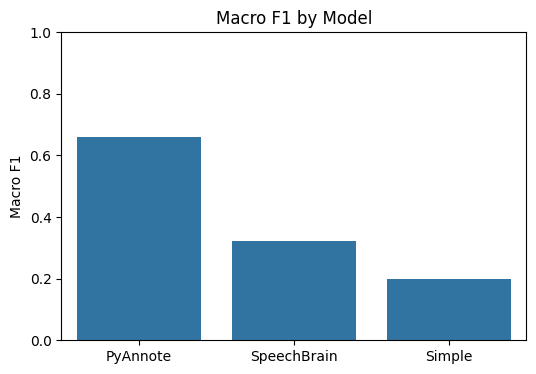

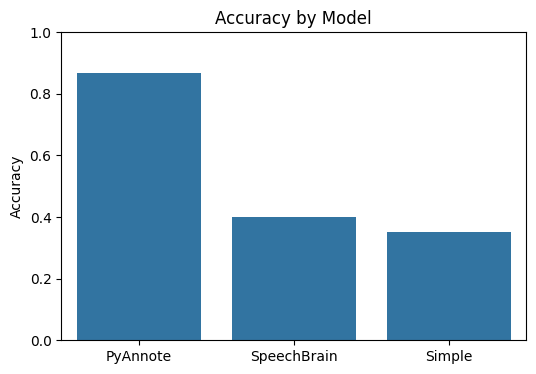

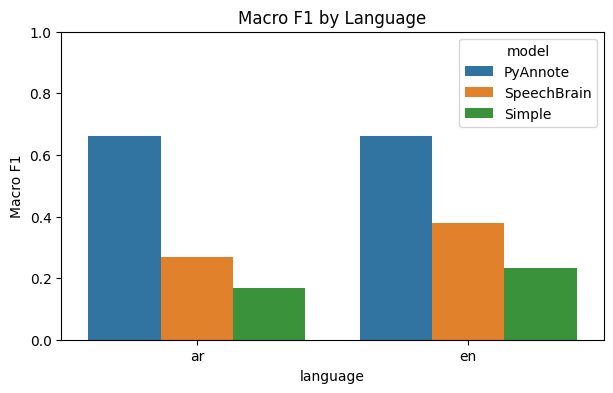

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(data=summary, x="model", y="f1_macro")
plt.ylim(0,1); plt.ylabel("Macro F1"); plt.xlabel(""); plt.title("Macro F1 by Model")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=summary, x="model", y="accuracy")
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.xlabel(""); plt.title("Accuracy by Model")
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=by_lang, x="language", y="f1_macro", hue="model")
plt.ylim(0,1); plt.ylabel("Macro F1"); plt.title("Macro F1 by Language"); plt.show()


## 5. Confusion Matrices by Model
This section visualizes confusion matrices for each model, showing prediction accuracy for each class.

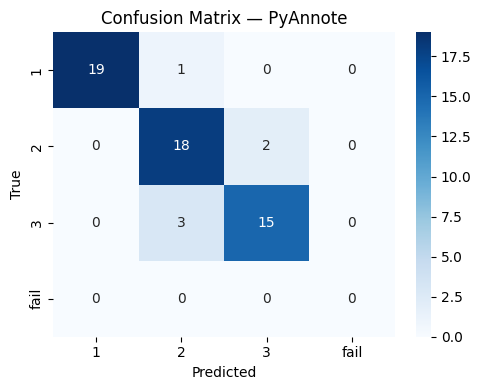

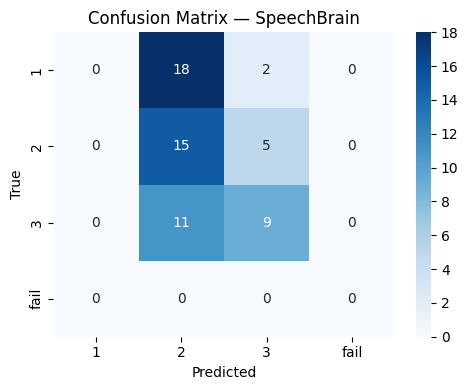

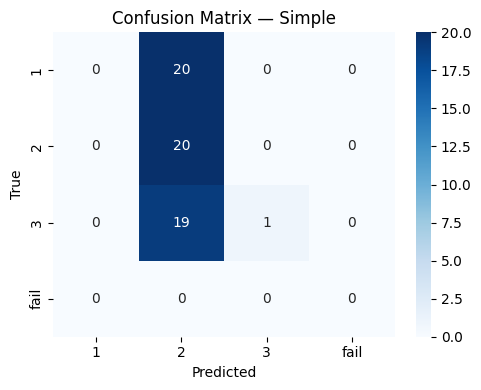

In [11]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"
files = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

labels = [1,2,3,-1]  # include fail bucket if any

for name, p in files.items():
    dfp = pd.read_csv(p)
    y_true = dfp["true_speakers"].astype(int)
    y_pred = dfp["pred_speakers"].fillna(-1).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1,2,3,"fail"], yticklabels=[1,2,3,"fail"])
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()


## 6. Confusion Matrices by Model and Language
This section visualizes confusion matrices for each model, broken down by language.

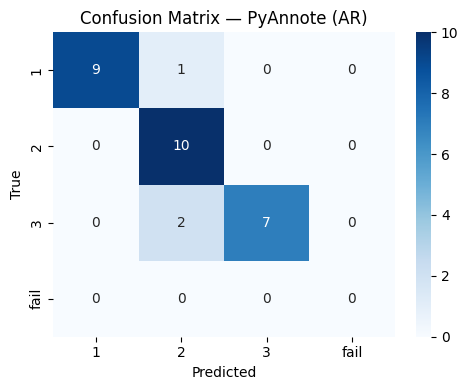

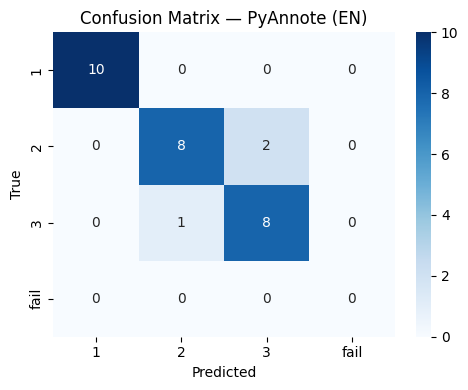

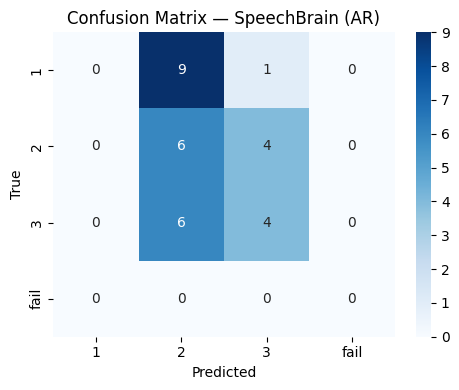

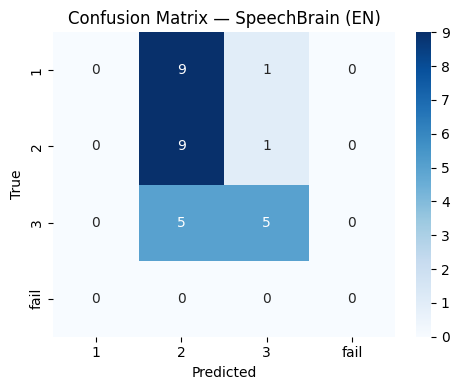

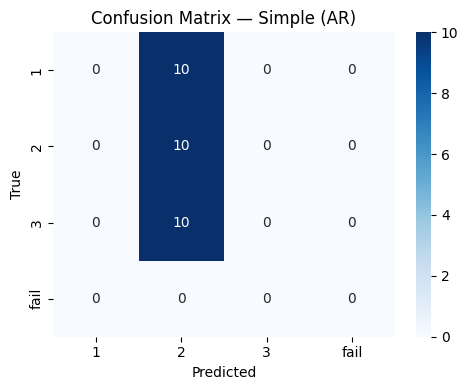

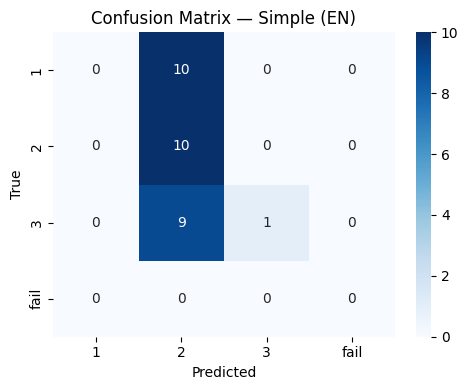

In [12]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"
files = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

labels = [1,2,3,-1]

for name, p in files.items():
    dfp = pd.read_csv(p)
    for lang, sub in dfp.groupby("language"):
        y_true = sub["true_speakers"].astype(int)
        y_pred = sub["pred_speakers"].fillna(-1).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=labels)

        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[1,2,3,"fail"], yticklabels=[1,2,3,"fail"])
        plt.title(f"Confusion Matrix — {name} ({lang.upper()})")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout(); plt.show()


## 7. Accuracy by True Class
This section computes and displays accuracy for each true speaker count class, across all models.

In [13]:
import pandas as pd
from pathlib import Path
import numpy as np

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"
files = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

rows = []
for name, p in files.items():
    dfp = pd.read_csv(p)
    dfp = dfp.assign(pred = dfp["pred_speakers"].fillna(-1).astype(int),
                     true = dfp["true_speakers"].astype(int))
    for cls in [1,2,3]:
        sub = dfp[dfp["true"]==cls]
        acc = (sub["true"] == sub["pred"]).mean() if len(sub) else np.nan
        rows.append({"model": name, "true_class": cls, "class_accuracy": acc, "n": len(sub)})

acc_by_cls = pd.DataFrame(rows).sort_values(["true_class","class_accuracy"], ascending=[True,False])
print("=== Accuracy by true class ===")
display(acc_by_cls)


=== Accuracy by true class ===


,model,true_class,class_accuracy,n
0,PyAnnote,1,0.95,20
3,SpeechBrain,1,0.00,20
6,Simple,1,0.00,20
7,Simple,2,1.00,20
1,PyAnnote,2,0.90,20
4,SpeechBrain,2,0.75,20
2,PyAnnote,3,0.75,20
5,SpeechBrain,3,0.45,20
8,Simple,3,0.05,20


## 8. Per-Language, Per-Class Metrics
This section computes and displays precision, recall, and F1 for each class and language, for each model.

In [14]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"
files = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

rows = []
for name, p in files.items():
    dfp = pd.read_csv(p)
    for lang, sub in dfp.groupby("language"):
        rep = classification_report(
            sub["true_speakers"].astype(int),
            sub["pred_speakers"].fillna(-1).astype(int),
            digits=3, zero_division=0, output_dict=True
        )
        for cls in ["1","2","3"]:
            if cls in rep:
                rows.append({
                    "model": name,
                    "language": lang,
                    "class": int(cls),
                    "precision": rep[cls]["precision"],
                    "recall": rep[cls]["recall"],
                    "f1": rep[cls]["f1-score"],
                    "support": int(rep[cls]["support"]),
                })

per_lang_class = pd.DataFrame(rows).sort_values(["language","class","f1"], ascending=[True,True,False])
print("=== Per-language, per-class metrics ===")
display(per_lang_class)


=== Per-language, per-class metrics ===


,model,language,class,precision,recall,f1,support
0,PyAnnote,ar,1,1.000000,0.9,0.947368,10
6,SpeechBrain,ar,1,0.000000,0.0,0.000000,10
12,Simple,ar,1,0.000000,0.0,0.000000,10
1,PyAnnote,ar,2,0.769231,1.0,0.869565,10
13,Simple,ar,2,0.333333,1.0,0.500000,10
7,SpeechBrain,ar,2,0.285714,0.6,0.387097,10
2,PyAnnote,ar,3,1.000000,0.7,0.823529,10
8,SpeechBrain,ar,3,0.444444,0.4,0.421053,10
14,Simple,ar,3,0.000000,0.0,0.000000,10
3,PyAnnote,en,1,1.000000,1.0,1.000000,10


## 9. Class-wise Accuracy (Per True Speaker Count and Language)
This section computes and displays class-wise accuracy for each model, both overall and per language.

In [18]:
import numpy as np

rows = []
for name, p in files.items():
    dfp = pd.read_csv(p)
    dfp = dfp.assign(true = dfp["true_speakers"].astype(int),
                     pred = dfp["pred_speakers"].fillna(-1).astype(int),
                     model=name)
    # overall per true class
    for cls in [1,2,3]:
        sub = dfp[dfp["true"] == cls]
        acc = (sub["true"] == sub["pred"]).mean() if len(sub) else np.nan
        rows.append({"model": name, "language": "ALL", "true_class": cls, "n": len(sub), "class_acc": acc})
    # per language
    for lang, g in dfp.groupby("language"):
        for cls in [1,2,3]:
            sub = g[g["true"] == cls]
            acc = (sub["true"] == sub["pred"]).mean() if len(sub) else np.nan
            rows.append({"model": name, "language": lang, "true_class": cls, "n": len(sub), "class_acc": acc})

class_acc = pd.DataFrame(rows).sort_values(["model","language","true_class"])
print("Class-wise accuracy (per true speaker count):")
display(class_acc)


Class-wise accuracy (per true speaker count):


,model,language,true_class,n,class_acc
0,PyAnnote,ALL,1,20,0.95
1,PyAnnote,ALL,2,20,0.90
2,PyAnnote,ALL,3,20,0.75
3,PyAnnote,ar,1,10,0.90
4,PyAnnote,ar,2,10,1.00
5,PyAnnote,ar,3,10,0.70
6,PyAnnote,en,1,10,1.00
7,PyAnnote,en,2,10,0.80
8,PyAnnote,en,3,10,0.80
18,Simple,ALL,1,20,0.00


## 10. Per-Class Accuracy Comparison Plot
This section visualizes per-class accuracy across all models using a bar plot.

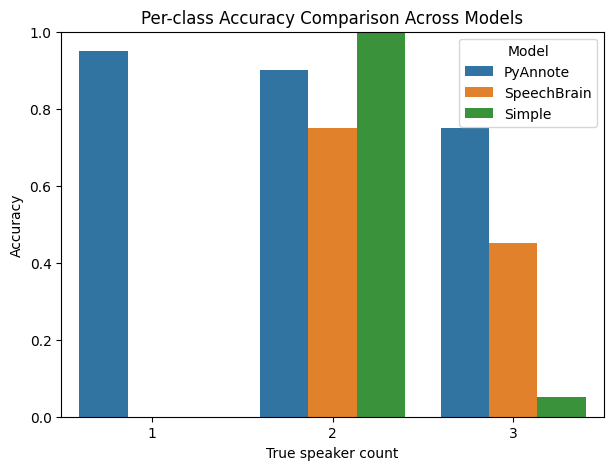

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# reload all predictions
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"
files = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

rows = []
for name, p in files.items():
    dfp = pd.read_csv(p).assign(model=name)
    dfp["true"] = dfp["true_speakers"].astype(int)
    dfp["pred"] = dfp["pred_speakers"].fillna(-1).astype(int)
    for cls in [1,2,3]:
        sub = dfp[dfp["true"] == cls]
        acc = (sub["true"] == sub["pred"]).mean() if len(sub) else float("nan")
        rows.append({"model": name, "true_class": cls, "accuracy": acc, "n": len(sub)})

class_comp = pd.DataFrame(rows)

# plot
plt.figure(figsize=(7,5))
sns.barplot(data=class_comp, x="true_class", y="accuracy", hue="model")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("True speaker count")
plt.title("Per-class Accuracy Comparison Across Models")
plt.legend(title="Model")
plt.show()
